# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [5]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [6]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [7]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [9]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [10]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [11]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

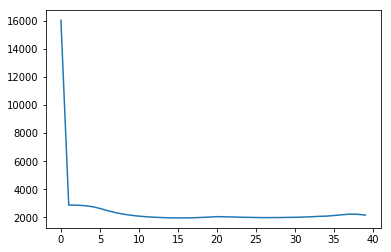

In [12]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [14]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print(word)
    print('')

sbj0: 
который
быть
что
это
человек
этот
как
свой
для
они
его
весь
такой
время
себя

sbj1: 
возведение
a
b
множитель
раскладывать
x
выражение
умножение
скобка
разложение
сокращенный
квадрат
ответ
переменный
целый

sbj2: 
обособление
куприн
слово
раскольников
мастер
роман
словосочетание
маргарита
подчинительный
соня
оборот
вера
браслет
старик
сантьяго

sbj3: 
который
быть
год
свой
время
государство
человек
мир
становиться
северный
жизнь
первый
война
африка
ребенок

sbj4: 
x
a
b
уравнение
дробь
квадратный
y
степень
функция
число
f
решение
корень
c
пример

sbj5: 
быть
год
пушкин
функция
свой
его
русский
который
поэт
империя
a
культура
весь
f
трение

sbj6: 
сила
быть
тело
энергия
поле
при
магнитный
точка
географический
наречие
если
частица
например
заряд
величина

sbj7: 
который
что
это
как
человек
для
этот
такой
быть
являться
мочь
себя
она
его
свой

sbj8: 
который
быть
что
это
свой
как
этот
человек
для
x
они
такой
государство
a
весь

sbj9: 
который
быть
что
этот
это
как
человек
свой
для
т

Давайте посмотрим также на разреженность матриц:

In [16]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7333747148513794
0.1655462235212326


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [17]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [18]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [24]:
def print_last_words():
    for topic_name in model_artm.topic_names:
        print(topic_name + ': ')
        tokens = model_artm.score_tracker["top_words"].last_tokens
        for word in tokens.get(topic_name, []):    
            print(word)
        print('')
print_last_words()

sbj0: 
предложение
вода
корень
древний
квадратный
дом
n
океан
жить
собственный
крестьянин
член
александр
зона
достигать

sbj1: 

sbj2: 

sbj3: 
северный
африка
ресурс
сфера
географический
конфликт
климат
цивилизация
международный
ядерный
гражданин
материк
остров
организация
среда

sbj4: 

sbj5: 
функция
пушкин
империя
f
определение
область
промежуток
восстание
трение
существительное
английский
пояс
павел
падеж
оборот

sbj6: 

sbj7: 
лермонтов
поэма
толстой
правило
иван
лиза
мертвый
общение
средство
хотеть
детство
относительно
поведение
ничто
одиночество

sbj8: 
x
a
два
b
ребенок
город
равный
уравнение
сторона
y
движение
условие
различный
решение
поле

sbj9: 
который
быть
что
это
этот
человек
как
свой
для
такой
они
весь
его
год
жизнь



In [21]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.8179576396942139
0.3355042040348053


Попробуем менять коэффициент регуляризации:

In [22]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [23]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [25]:
print_last_words()

sbj0: 
предложение
вода
корень
древний
квадратный
дом
n
океан
жить
собственный
крестьянин
член
александр
зона
достигать

sbj1: 

sbj2: 

sbj3: 
северный
африка
ресурс
сфера
географический
конфликт
климат
цивилизация
международный
ядерный
гражданин
материк
остров
организация
среда

sbj4: 

sbj5: 
функция
пушкин
империя
f
определение
область
промежуток
восстание
трение
существительное
английский
пояс
павел
падеж
оборот

sbj6: 

sbj7: 
лермонтов
поэма
толстой
правило
иван
лиза
мертвый
общение
средство
хотеть
детство
относительно
поведение
ничто
одиночество

sbj8: 
x
a
два
b
ребенок
город
равный
уравнение
сторона
y
движение
условие
различный
решение
поле

sbj9: 
который
быть
что
это
этот
человек
как
свой
для
такой
они
весь
его
год
жизнь



In [26]:
# еще раз посмотрим на разреженность
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9119634628295898
0.5050420165061951


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [31]:
model_artm.save("my_model")

In [32]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [33]:
phi = model_artm.get_phi()

In [34]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
"(text, бивень)",0.000000,0.0,0.0,0.0,0.0,0.000138,0.0,0.000000,0.0,0.0
"(text, фигурка)",0.000000,0.0,0.0,0.0,0.0,0.000138,0.0,0.000000,0.0,0.0
"(text, мамонт)",0.000000,0.0,0.0,0.0,0.0,0.000276,0.0,0.000000,0.0,0.0
"(text, неандерталец)",0.000000,0.0,0.0,0.0,0.0,0.000138,0.0,0.000000,0.0,0.0
"(text, неандертальский)",0.000000,0.0,0.0,0.0,0.0,0.000138,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
"(text, областной)",0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000288,0.0,0.0
"(text, выталкивать)",0.000000,0.0,0.0,0.0,0.0,0.000138,0.0,0.000000,0.0,0.0
"(text, селенга)",0.000071,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
"(text, вскользь)",0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000288,0.0,0.0


Матрица вероятностей тем в документах.

In [35]:
theta = model_artm.get_theta()
theta

,100,101,102,103,104,105,106,107,108,109,...,466,467,468,469,470,471,472,473,474,475
sbj0,0.041801,0.071918,0.030556,0.085106,0.159864,0.044164,0.150769,0.091703,0.060201,0.024096,...,0.057269,0.020911,0.042208,0.080247,0.058264,0.049123,0.081560,0.057143,0.075075,0.060897
sbj1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj3,0.032154,0.257862,0.008333,0.334073,0.060528,0.011041,0.061538,0.026201,0.003344,0.088353,...,0.061674,0.025974,0.055195,0.018519,0.006522,0.010526,0.053192,0.019048,0.069069,0.025641
sbj4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj5,0.013156,0.109589,0.005556,0.012766,0.027211,0.052224,0.033846,0.074236,0.036789,0.008032,...,0.145374,0.144216,0.113181,0.089506,0.354780,0.084211,0.138298,0.009524,0.198198,0.099359
sbj6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj7,0.101986,0.003425,0.295483,0.017021,0.023810,0.240530,0.030742,0.087305,0.006689,0.072289,...,0.021928,0.000458,0.003702,0.032260,0.008696,0.063158,0.000000,0.030661,0.000000,0.021379
sbj8,0.048845,0.154110,0.058731,0.102128,0.119048,0.062078,0.073873,0.087368,0.217391,0.068273,...,0.189526,0.077922,0.090909,0.066506,0.058696,0.052632,0.067376,0.083625,0.078078,0.049134
sbj9,0.762058,0.403097,0.601342,0.448905,0.609541,0.589963,0.649231,0.633188,0.675585,0.738956,...,0.524229,0.730519,0.694805,0.712963,0.513043,0.740351,0.659574,0.800000,0.579579,0.743590


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [36]:
theta_test = model_artm.transform(batch_vectorizer)